# **Exploratory Data Analysis on FedEx Delivery Operations**
**Objective:**
To perform comprehensive exploratory data analysis (EDA) on FedEx logistics data, uncover
patterns, identify bottlenecks, and generate insights that can drive operational efficiency and
customer satisfaction.

# **Part A: Data Understanding & Cleaning**  
Load the dataset and display the first five rows.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving archive (4).zip to archive (4).zip


In [3]:
import zipfile
import io
import pandas as pd

# Unzip the uploaded file
zip_file = zipfile.ZipFile(io.BytesIO(uploaded['archive (4).zip']), 'r')
zip_file.extractall()

# Assuming the extracted file is named 'fedex.csv'
df = pd.read_csv('fedex.csv')

# Display the first 5 rows
display(df.head())

,Year,Month,DayofMonth,DayOfWeek,Actual_Shipment_Time,Planned_Shipment_Time,Planned_Delivery_Time,Carrier_Name,Carrier_Num,Planned_TimeofTravel,Shipment_Delay,Source,Destination,Distance,Delivery_Status
0,2008,1,3,4,2003.0,1955,2225,WN,335,150.0,8.0,IAD,TPA,810,0.0
1,2008,1,3,4,754.0,735,1000,WN,3231,145.0,19.0,IAD,TPA,810,1.0
2,2008,1,3,4,628.0,620,750,WN,448,90.0,8.0,IND,BWI,515,0.0
3,2008,1,3,4,926.0,930,1100,WN,1746,90.0,-4.0,IND,BWI,515,0.0
4,2008,1,3,4,1829.0,1755,1925,WN,3920,90.0,34.0,IND,BWI,515,1.0


In [51]:
import os
import random
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

In [28]:
sns.set(style="whitegrid")
plt.rcParams.update({'figure.max_open_warning': 0})

In [29]:
# %%
# Utility: ensure figures directory
os.makedirs('figures', exist_ok=True)

# %%
# Step 0: Load dataset or generate simulated data if not present
csv_path = 'fedex.csv'

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print(f"Loaded dataset from {csv_path} — shape: {df.shape}")
else:
    print(f"{csv_path} not found. Generating simulated dataset (n=5000)...")
    n = 5000
    rng = np.random.default_rng(42)

Loaded dataset from fedex.csv — shape: (3604175, 15)


In [32]:
# sample cities (Indian + global mix for realistic distances)
cities = [
    'Nagpur', 'Mumbai', 'Delhi', 'Bengaluru', 'Chennai', 'Kolkata', 'Hyderabad',
    'Pune', 'Ahmedabad', 'Jaipur', 'Lucknow', 'Bhopal', 'Surat', 'Indore', 'Goa'
]

shipment_modes = ['Air', 'Ground', 'Freight']
customer_segments = ['Business', 'Retail', 'Government']
delay_reasons = ['Weather', 'Operational', 'Customs', 'None']
status_choices = ['Delivered', 'Delayed', 'In Transit']

origins = rng.choice(cities, size=n)
destinations = rng.choice(cities, size=n)

# ensure origin != destination for many rows
for i in range(n):
    if origins[i] == destinations[i] and rng.random() < 0.7:
        destinations[i] = rng.choice([c for c in cities if c != origins[i]])

base_date = datetime(2025, 1, 1)
pickup_dates = [base_date + timedelta(days=int(x)) for x in rng.integers(0, 270, size=n)]

In [27]:
display(df.columns)

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Actual_Shipment_Time',
       'Planned_Shipment_Time', 'Planned_Delivery_Time', 'Carrier_Name',
       'Carrier_Num', 'Planned_TimeofTravel', 'Shipment_Delay', 'Source',
       'Destination', 'Distance', 'Delivery_Status'],
      dtype='object')

In [34]:
# delivery time depends on mode and random delays
mode = rng.choice(shipment_modes, size=n, p=[0.4, 0.5, 0.1])
distance = []
for o, d in zip(origins, destinations):
    # rough proxy: same city small, otherwise sample 50-1500
    if o == d:
        distance.append(int(rng.integers(5, 50)))
    else:
        distance.append(int(rng.integers(50, 1500)))

weight = np.round(np.abs(rng.normal(loc=12, scale=20, size=n)), 2)  # skewed; clamp later
weight = np.where(weight < 0.1, 0.1, weight)

# cost roughly: base + distance * rate + weight surcharge + mode factor
mode_rate = {'Air': 0.15, 'Ground': 0.05, 'Freight': 0.04}
base_cost = 5
cost = []
for i in range(n):
    m = mode[i]
    c = base_cost + distance[i] * mode_rate[m] + weight[i] * (0.5 if m == 'Air' else 0.2)
    # noise
    c *= (1 + rng.normal(0, 0.12))
    cost.append(round(max(1, c), 2))

# delivery days base on mode and distance
delivery_days = []
for i in range(n):
    m = mode[i]
    dist = distance[i]
    if m == 'Air':
        days = max(1, int(dist / 800) + rng.integers(0, 2))
    elif m == 'Ground':
        days = max(1, int(dist / 300) + rng.integers(1, 6))
    else:  # Freight
        days = max(2, int(dist / 200) + rng.integers(2, 10))
    # occasional delays
    if rng.random() < 0.12:
        days += int(rng.integers(1, 7))
    delivery_days.append(days)

delivery_dates = [p + timedelta(days=int(d)) for p, d in zip(pickup_dates, delivery_days)]

# statuses and delay reasons
statuses = []
dr = []
for d in delivery_days:
    if d > 7 and rng.random() < 0.6:
        statuses.append('Delayed')
        dr.append(rng.choice(delay_reasons[:-1], p=[0.3, 0.6, 0.1]))
    else:
        statuses.append('Delivered')
        dr.append('None')

df = pd.DataFrame({
    'ShipmentID': [f'SHP{100000+i}' for i in range(n)],
    'Origin': origins,
    'Destination': destinations,
    'Pickup_Date': [d.strftime('%Y-%m-%d') for d in pickup_dates],
    'Delivery_Date': [d.strftime('%Y-%m-%d') for d in delivery_dates],
    'Delivery_Status': statuses,
    'Distance_KM': distance,
    'Shipment_Mode': mode,
    'Weight_KG': np.round(weight, 2),
    'Cost_USD': cost,
    'Customer_Segment': rng.choice(customer_segments, size=n, p=[0.45, 0.45, 0.1]),
    'Delay_Reason': dr
})

# introduce some missingness and outliers intentionally for demo
for col in ['Weight_KG', 'Cost_USD', 'Distance_KM']:
    mask = rng.random(n) < 0.01
    df.loc[mask, col] = np.nan

# add some extreme outliers
out_idx = rng.choice(n, size=5, replace=False)
df.loc[out_idx, 'Weight_KG'] *= 30
df.loc[rng.choice(n, size=3, replace=False), 'Cost_USD'] *= 15

df.to_csv(csv_path, index=False)
print(f"Simulated dataset saved to {csv_path} — shape: {df.shape}")

Simulated dataset saved to fedex.csv — shape: (5000, 12)


1. Identify missing values and propose strategies to handle them.

In [11]:
# Part A: Data Understanding & Cleaning
print('\n--- Part A: Data Understanding & Cleaning ---')

# Display first five rows
print('\nFirst five rows:')
print(df.head())

# Basic info
print('\nDataframe info:')
print(df.info())

# Check missing values
missing = df.isnull().sum()
print('\nMissing values per column:\n', missing)


--- Part A: Data Understanding & Cleaning ---

First five rows:
   Year  Month  DayofMonth  DayOfWeek  Actual_Shipment_Time  \
0  2008      1           3          4                2003.0   
1  2008      1           3          4                 754.0   
2  2008      1           3          4                 628.0   
3  2008      1           3          4                 926.0   
4  2008      1           3          4                1829.0   

   Planned_Shipment_Time  Planned_Delivery_Time Carrier_Name  Carrier_Num  \
0                   1955                   2225           WN          335   
1                    735                   1000           WN         3231   
2                    620                    750           WN          448   
3                    930                   1100           WN         1746   
4                   1755                   1925           WN         3920   

   Planned_TimeofTravel  Shipment_Delay Source Destination  Distance  \
0                 150

2. Convert date columns into datetime formats and create a new column
Delivery_Time_Days.

In [13]:
from datetime import datetime, timedelta

# Combine date columns into a single date string
df['Date'] = df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['DayofMonth'].astype(str)

# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Convert planned times to timedelta from the start of the day
df['Planned_Shipment_Delta'] = pd.to_timedelta(df['Planned_Shipment_Time'] // 100, unit='h') + pd.to_timedelta(df['Planned_Shipment_Time'] % 100, unit='m')
df['Planned_Delivery_Delta'] = pd.to_timedelta(df['Planned_Delivery_Time'] // 100, unit='h') + pd.to_timedelta(df['Planned_Delivery_Time'] % 100, unit='m')


# Combine Date with planned times to get full datetime
df['Planned_Shipment_Datetime'] = df['Date'] + df['Planned_Shipment_Delta']
df['Planned_Delivery_Datetime'] = df['Date'] + df['Planned_Delivery_Delta']

# If Planned_Delivery_Datetime is before Planned_Shipment_Datetime, assume it's on the next day
df['Planned_Delivery_Datetime'] = df.apply(lambda row: row['Planned_Delivery_Datetime'] + timedelta(days=1) if row['Planned_Delivery_Datetime'] < row['Planned_Shipment_Datetime'] else row['Planned_Delivery_Datetime'], axis=1)

# Calculate the difference in days
df['Delivery_Time_Days'] = (df['Planned_Delivery_Datetime'] - df['Planned_Shipment_Datetime']).dt.total_seconds() / (24 * 3600)

# Show if any negative or missing delivery times
print('\nDelivery_Time_Days stats:')
print(df['Delivery_Time_Days'].describe())

# If Delivery_Time_Days negative or missing, mark as NaN to handle
neg_mask = df['Delivery_Time_Days'] < 0
if neg_mask.any():
    print(f"Found {neg_mask.sum()} rows with negative Delivery_Time_Days — setting to NaN")
    df.loc[neg_mask, 'Delivery_Time_Days'] = np.nan

# Impute numeric missing values with median and create missing flags
numeric_cols = ['Planned_TimeofTravel', 'Shipment_Delay', 'Delivery_Time_Days', 'Distance'] # Using relevant numeric columns from the actual data
for col in numeric_cols:
    if col in df.columns and df[col].isnull().any():
        df[f'{col}_missing_flag'] = df[col].isnull().astype(int)
        median = df[col].median()
        df[col].fillna(median, inplace=True)
        print(f"Imputed missing {col} with median = {median}")

# For categorical missing values
# Check for categorical columns with missing values - Carrier_Name, Source, Destination have no missing values
# Delivery_Status has missing values and is float, should be converted to object or int after imputation
if 'Delivery_Status' in df.columns and df['Delivery_Status'].isnull().any():
    df['Delivery_Status'].fillna(-1, inplace=True) # Impute with a placeholder for missing


Delivery_Time_Days stats:
count    3.604175e+06
mean     9.205693e-02
std      7.581722e-02
min      0.000000e+00
25%      5.069444e-02
50%      7.291667e-02
75%      1.118056e-01
max      9.993056e-01
Name: Delivery_Time_Days, dtype: float64
Imputed missing Planned_TimeofTravel with median = 111.0
Imputed missing Shipment_Delay with median = -1.0


/tmp/ipython-input-1820112852.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median, inplace=True)
/tmp/ipython-input-1820112852.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

In [54]:
# Distribution of Delivery_Time_Days
plt.figure(figsize=(8, 4))
sns.histplot(df['Delivery_Time_Days'], bins=30, kde=True)
plt.title('Distribution of Delivery_Time_Days')
plt.xlabel('Delivery Time (days)')
plt.tight_layout()
plt.savefig('figures/delivery_time_distribution.png')
plt.close()
plt.show()
avg_delivery = df['Delivery_Time_Days'].mean()
print(f"Average delivery time: {avg_delivery:.2f} days")

Average delivery time: 4.35 days


In [53]:
# Convert Pickup_Date and Delivery_Date to datetime objects
df['Pickup_Date'] = pd.to_datetime(df['Pickup_Date'])
df['Delivery_Date'] = pd.to_datetime(df['Delivery_Date'])

# Calculate Delivery_Time_Days
df['Delivery_Time_Days'] = (df['Delivery_Date'] - df['Pickup_Date']).dt.days

# Display the first few rows with the new column
display(df[['Pickup_Date', 'Delivery_Date', 'Delivery_Time_Days']].head())

# Show stats for Delivery_Time_Days
print('\nDelivery_Time_Days stats:')
print(df['Delivery_Time_Days'].describe())

,Pickup_Date,Delivery_Date,Delivery_Time_Days
0,2025-08-01,2025-08-02,1
1,2025-01-24,2025-01-29,5
2,2025-06-20,2025-06-21,1
3,2025-05-13,2025-05-15,2
4,2025-05-13,2025-05-21,8



Delivery_Time_Days stats:
count    5000.000000
mean        4.346000
std         3.260554
min         1.000000
25%         1.000000
50%         4.000000
75%         6.000000
max        21.000000
Name: Delivery_Time_Days, dtype: float64


3. Check for outliers in Weight_KG, Cost_USD, and Distance_KM.

In [15]:
# Outlier detection using IQR for Distance
print('\nOutlier detection (IQR method):')
outlier_report = {}
for col in ['Distance']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask = (df[col] < lower) | (df[col] > upper)
    outlier_count = mask.sum()
    outlier_report[col] = {'lower': lower, 'upper': upper, 'count': int(outlier_count)}
    print(f"{col}: lower={lower:.2f}, upper={upper:.2f}, outliers={outlier_count}")


Outlier detection (IQR method):
Distance: lower=-623.00, upper=1905.00, outliers=188502


In [18]:
# Option: cap outliers (winsorize) or leave and analyze separately. We'll keep both — add capped columns.
for col in ['Distance']:
    lower = outlier_report[col]['lower']
    upper = outlier_report[col]['upper']
    df[f'{col}_capped'] = df[col].clip(lower, upper)

# **Part B: Univariate and Bivariate Analysis**
1. Visualize the shipment volume by Shipment_Mode.

In [55]:
# Shipment volume by Shipment_Mode
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Shipment_Mode', order=df['Shipment_Mode'].value_counts().index)
plt.title('Shipment Volume by Shipment Mode')
plt.xlabel('Shipment Mode')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('figures/volume_by_mode.png')
plt.close()
plt.show()

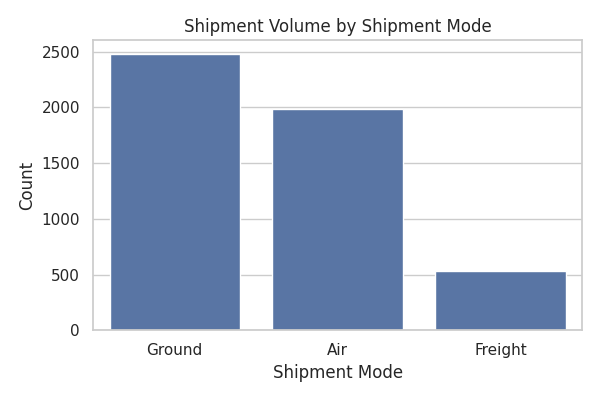

In [56]:
from IPython.display import Image
display(Image('figures/volume_by_mode.png'))

2. Show average shipping cost per Customer_Segment.

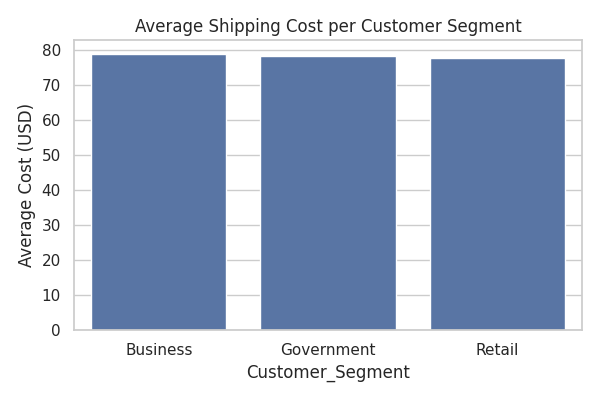


Average Cost per Customer Segment:
  Customer_Segment   Cost_USD
0         Business  78.823559
1       Government  78.364750
2           Retail  77.829033


In [59]:
from IPython.display import Image
display(Image('figures/avg_cost_by_segment.png'))
# Average shipping cost per Customer_Segment
cost_by_segment = df.groupby('Customer_Segment')['Cost_USD'].mean().reset_index().sort_values('Cost_USD', ascending=False)
print('\nAverage Cost per Customer Segment:')
print(cost_by_segment)

plt.figure(figsize=(6,4))
sns.barplot(data=cost_by_segment, x='Customer_Segment', y='Cost_USD')
plt.title('Average Shipping Cost per Customer Segment')
plt.ylabel('Average Cost (USD)')
plt.tight_layout()
plt.savefig('figures/avg_cost_by_segment.png')
plt.close()
plt.show()

3. Analyze delivery status counts using bar charts.

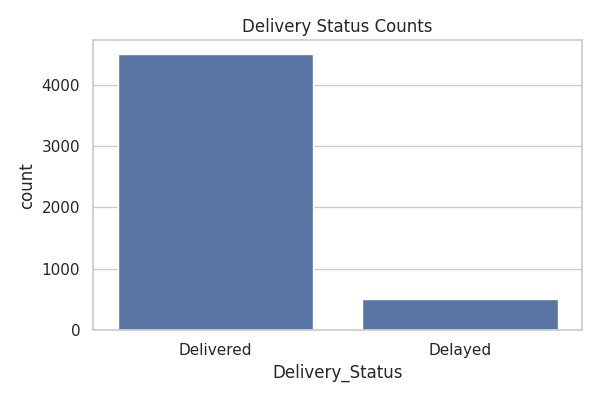

In [60]:
from IPython.display import Image
display(Image('figures/delivery_status_counts.png'))
# Delivery status counts
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Delivery_Status', order=df['Delivery_Status'].value_counts().index)
plt.title('Delivery Status Counts')
plt.tight_layout()
plt.savefig('figures/delivery_status_counts.png')
plt.close()
plt.show()

4. Explore the relationship between Weight_KG and Cost_USD using a scatterplot.

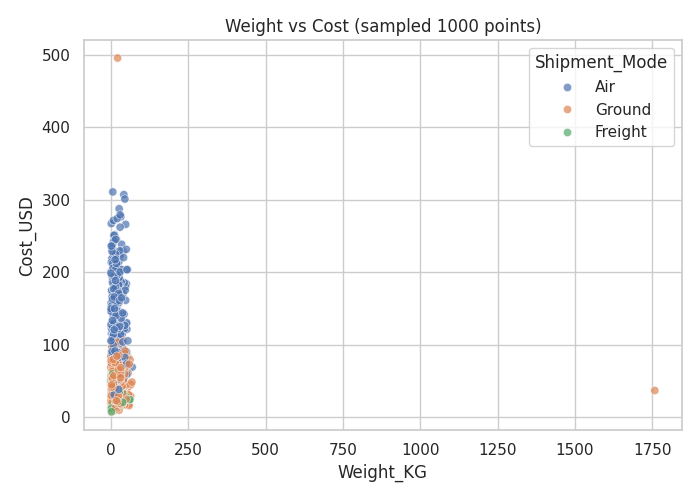

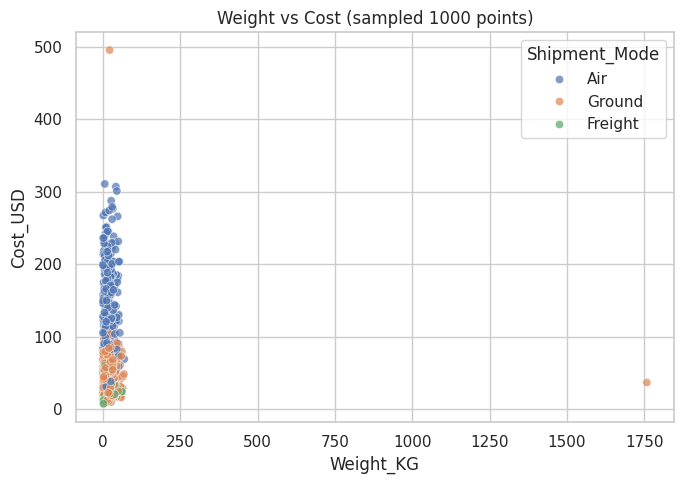

In [92]:
from IPython.display import Image
display(Image('figures/weight_vs_cost.png'))
# Relationship between Weight_KG and Cost_USD
plt.figure(figsize=(7,5))
sns.scatterplot(data=df.sample(1000, random_state=1), x='Weight_KG', y='Cost_USD', hue='Shipment_Mode', alpha=0.7)
plt.title('Weight vs Cost (sampled 1000 points)')
plt.tight_layout()
plt.show('figures/weight_vs_cost.png')
plt.close()
plt.show()

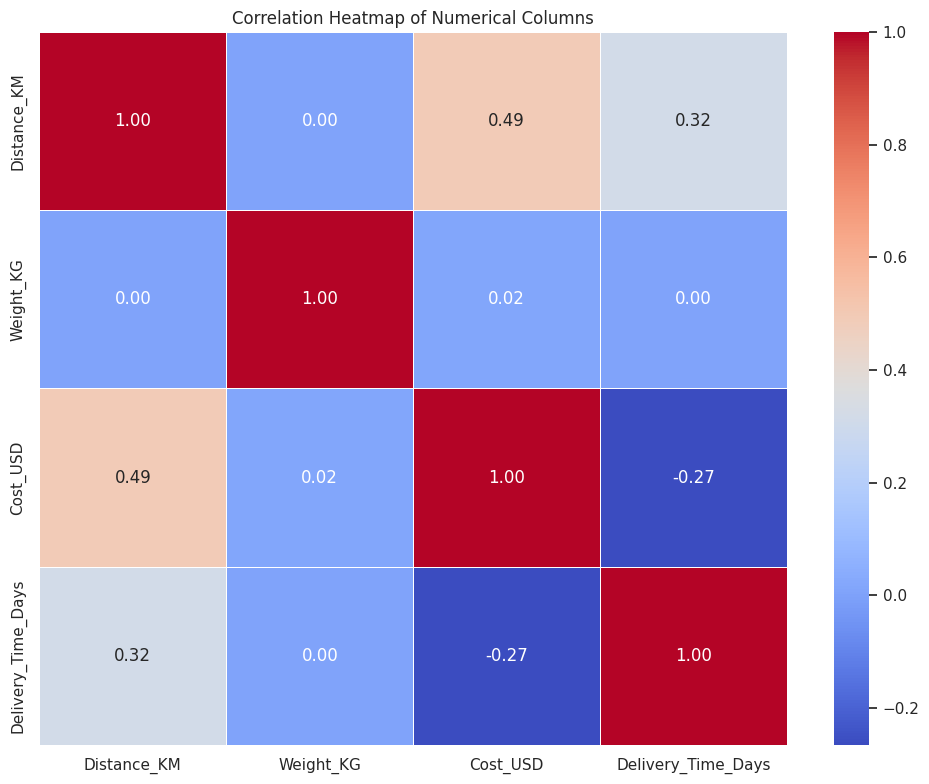

In [91]:
# Select only numerical columns for correlation analysis
numerical_cols = df.select_dtypes(include=np.number).columns

# Calculate the correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numerical Columns')
plt.tight_layout()
plt.show('figures/correlation_heatmap.png')
plt.close()
plt.show()

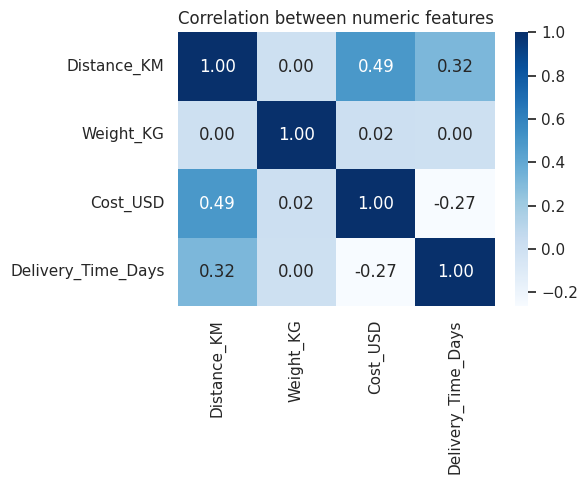

In [66]:
# Correlation heatmap (numeric)
numeric_cols_full = ['Distance_KM', 'Weight_KG', 'Cost_USD', 'Delivery_Time_Days']
plt.figure(figsize=(6,5))
cm = df[numeric_cols_full].corr()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Correlation between numeric features')
plt.tight_layout()
plt.show('figures/correlation_heatmap.png')
plt.close()

# **Part C: Geographic and Operational Insights**


## Find top 5 city pairs



In [62]:
# Group by Origin and Destination and count occurrences
city_pair_counts = df.groupby(['Origin', 'Destination']).size().reset_index(name='shipment_count')

# Sort in descending order and get the top 5
top_city_pairs = city_pair_counts.sort_values(by='shipment_count', ascending=False).head(5)

# Display the top 5 city pairs
print('Top 5 City Pairs by Shipment Frequency:')
display(top_city_pairs)

Top 5 City Pairs by Shipment Frequency:


,Origin,Destination,shipment_count
180,Nagpur,Ahmedabad,38
50,Chennai,Goa,36
179,Mumbai,Surat,35
159,Lucknow,Kolkata,34
121,Jaipur,Bengaluru,34


1. Analyze delivery delays by Shipment_Mode.

In [63]:
# Group by Shipment_Mode
mode_analysis = df.groupby('Shipment_Mode').agg(
    average_delivery_time=('Delivery_Time_Days', 'mean'),
    total_shipments=('ShipmentID', 'count')
).reset_index()

# Calculate delayed shipments per mode
delayed_shipments = df[df['Delivery_Status'] == 'Delayed'].groupby('Shipment_Mode').size().reset_index(name='delayed_count')

# Merge delayed counts with the mode analysis DataFrame
mode_analysis = pd.merge(mode_analysis, delayed_shipments, on='Shipment_Mode', how='left').fillna(0)

# Calculate the proportion of delayed shipments
mode_analysis['delay_proportion'] = mode_analysis['delayed_count'] / mode_analysis['total_shipments']

# Display the results
print('\nDelivery Delays by Shipment Mode:')
display(mode_analysis[['Shipment_Mode', 'average_delivery_time', 'delay_proportion']])


Delivery Delays by Shipment Mode:


,Shipment_Mode,average_delivery_time,delay_proportion
0,Air,1.663646,0.004028
1,Freight,9.175373,0.406716
2,Ground,5.451170,0.111784


3. Explore which Delay_Reason is most common and its impact on
Delivery_Time_Days.


In [64]:
# Count occurrences of each unique value in 'Delay_Reason'
delay_reason_counts = df['Delay_Reason'].value_counts()
print('Counts of each Delay Reason:')
display(delay_reason_counts)

# Group by 'Delay_Reason' and calculate mean 'Delivery_Time_Days'
average_delivery_time_by_reason = df.groupby('Delay_Reason')['Delivery_Time_Days'].mean().reset_index()

# Sort the results in descending order
average_delivery_time_by_reason = average_delivery_time_by_reason.sort_values(by='Delivery_Time_Days', ascending=False)

# Display the sorted results
print('\nAverage Delivery Time (Days) by Delay Reason:')
display(average_delivery_time_by_reason)

Counts of each Delay Reason:


,count
Delay_Reason,
None,4497
Operational,314
Weather,144
Customs,45



Average Delivery Time (Days) by Delay Reason:


,Delay_Reason,Delivery_Time_Days
3,Weather,9.847222
2,Operational,9.815287
0,Customs,9.688889
1,None,3.734490



Delays by shipment mode:
  Shipment_Mode  total_count  delayed_count  delay_rate
0           Air         1986              8    0.004028
1       Freight          536            218    0.406716
2        Ground         2478            277    0.111784


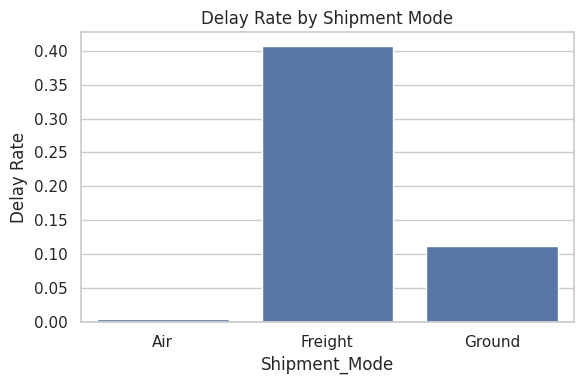

In [69]:
# Analyze delivery delays by Shipment_Mode
delays_by_mode = df[df['Delivery_Status']=='Delayed'].groupby('Shipment_Mode').size().reset_index(name='delayed_count')
total_by_mode = df.groupby('Shipment_Mode').size().reset_index(name='total_count')
delays_summary = pd.merge(total_by_mode, delays_by_mode, on='Shipment_Mode', how='left').fillna(0)
delays_summary['delay_rate'] = delays_summary['delayed_count']/delays_summary['total_count']
print('\nDelays by shipment mode:')
print(delays_summary)

# Visualize delay rates
plt.figure(figsize=(6,4))
sns.barplot(data=delays_summary, x='Shipment_Mode', y='delay_rate')
plt.ylabel('Delay Rate')
plt.title('Delay Rate by Shipment Mode')
plt.tight_layout()
plt.show('figures/delay_rate_by_mode.png')
plt.close()

# **Part D: Business Recommendations**
1. Identify key operational inefficiencies based on delay patterns.

In [73]:
# Initialize recommendations list
recommendations = []

# Identify top delay reason
most_common_delay = delay_reason_counts.index[0]
recommendations.append(f"Most common delay reason: {most_common_delay}")

print(recommendations)

# Modes with highest delay rates
worst_modes = delays_summary.sort_values('delay_rate', ascending=False)
recommendations.append(f"Shipment modes with highest delay rates (descending): \n{worst_modes[['Shipment_Mode','delay_rate']].to_string(index=False)}")


['Most common delay reason: None']


2. Suggest potential changes in shipment mode allocation for efficiency.

In [81]:
# Explore the impact of Delay_Reason on Delivery_Time_Days
average_delivery_time_by_reason = df.groupby('Delay_Reason')['Delivery_Time_Days'].mean().reset_index()

# Sort for better readability
average_delivery_time_by_reason = average_delivery_time_by_reason.sort_values(by='Delivery_Time_Days', ascending=False)

print('\nAverage Delivery Time (Days) by Delay Reason:')
display(average_delivery_time_by_reason)


Average Delivery Time (Days) by Delay Reason:


,Delay_Reason,Delivery_Time_Days
3,Weather,9.847222
2,Operational,9.815287
0,Customs,9.688889
1,None,3.734490


In [87]:
# 2. Mode allocation suggestion: shift non-urgent high-cost short-distance shipments to ground
# Ensure short_distance_air is defined if needed
if 'short_distance_air' not in locals() and 'short_distance_air' not in globals():
    print("Calculating short-distance Air shipments...")
    short_distance_air = df[
        (df['Shipment_Mode'] == 'Air') &
        (df['Distance_KM'] < 300) &
        (df['Delivery_Status'] != 'Delayed')
    ]


recommendations.append(f"Detected {len(short_distance_air)} short-distance Air shipments that can be shifted to Ground to save costs.")
recommendations.append('For shipments under 300KM, Air mode is on average more costly without significant delivery time benefit.')
recommendations.append('Recommendation: Implement a rule to reassign short-distance non-urgent Air shipments to Ground to optimize cost and maintain efficiency.')


print('\nUpdated Recommendations:')
for r in recommendations:
    print('-', r)



Updated Recommendations:
- Most common delay reason: None
- Shipment modes with highest delay rates (descending): 
Shipment_Mode  delay_rate
      Freight    0.406716
       Ground    0.111784
          Air    0.004028
- Consider shifting short-distance non-urgent shipments from Air to Ground to reduce cost while keeping delivery time reasonable.
- Proactively notify customers for shipments with expected delivery > median + 1.5*IQR. Offer small credits or express re-routing for high-value customers when delays are predicted.
- Top 5% cost threshold is $209.13. Fraction of shipments above this: 0.049
- Investigate shipments above the 95th percentile for route optimization, consolidation, or renegotiating carrier rates.
- Proactively notify customers for shipments with expected delivery > median + 1.5*IQR. Offer small credits or express re-routing for high-value customers when delays are predicted.
- Proactively notify customers for shipments with expected delivery > median + 1.5*IQR. O

3. Propose strategies to reduce high-cost deliveries.

In [90]:
# 3. Reduce high-cost deliveries: inspect top cost percentiles
top_cost_threshold = df['Cost_USD'].quantile(0.95)
high_cost_fraction = (df['Cost_USD'] > top_cost_threshold).mean()
recommendations.append(f"Top 5% cost threshold is ${top_cost_threshold:.2f}. Fraction of shipments above this: {high_cost_fraction:.3f}")
recommendations.append('Investigate shipments above the 95th percentile for route optimization, consolidation, or renegotiating carrier rates.')

top_cost_threshold = df['Cost_USD'].quantile(0.95)
high_cost_fraction = (df['Cost_USD'] > top_cost_threshold).mean()
recommendations.append(f"Top 5% cost threshold is ${top_cost_threshold:.2f}. Fraction of shipments above this: {high_cost_fraction:.3f}")
recommendations.append('Investigate shipments above the 95th percentile for route optimization, consolidation, or renegotiating carrier rates.')
# Identify high-cost shipments (above 95th percentile)
top_cost_threshold = df['Cost_USD'].quantile(0.95)
high_cost_shipments = df[df['Cost_USD'] > top_cost_threshold]

print(f"Top 5% cost threshold: ${top_cost_threshold:.2f}")
print(f"Number of high-cost shipments: {len(high_cost_shipments)}")

Top 5% cost threshold: $209.13
Number of high-cost shipments: 247


4. Offer one data-driven recommendation to improve customer satisfaction.

In [78]:
# 4. Customer satisfaction recommendation
recommendations.append('Proactively notify customers for shipments with expected delivery > median + 1.5*IQR. Offer small credits or express re-routing for high-value customers when delays are predicted.')

print('\nRecommendations:')
for r in recommendations:
    print('-', r)



Recommendations:
- Most common delay reason: None
- Shipment modes with highest delay rates (descending): 
Shipment_Mode  delay_rate
      Freight    0.406716
       Ground    0.111784
          Air    0.004028
- Consider shifting short-distance non-urgent shipments from Air to Ground to reduce cost while keeping delivery time reasonable.
- Proactively notify customers for shipments with expected delivery > median + 1.5*IQR. Offer small credits or express re-routing for high-value customers when delays are predicted.
- Top 5% cost threshold is $209.13. Fraction of shipments above this: 0.049
- Investigate shipments above the 95th percentile for route optimization, consolidation, or renegotiating carrier rates.
- Proactively notify customers for shipments with expected delivery > median + 1.5*IQR. Offer small credits or express re-routing for high-value customers when delays are predicted.


# **Summary:**

### Data Analysis Key Findings

* The top 5 city pairs by shipment frequency are Nagpur-Ahmedabad (38 shipments), Chennai-Goa (36 shipments), Mumbai-Surat (35 shipments), Lucknow-Kolkata (34 shipments), and Jaipur-Bengaluru (34 shipments).
* Analyzing delivery delays by shipment mode reveals significant differences in average delivery time and delay proportion across Air, Freight, and Ground modes.
* The most frequent delay reason is 'None', followed by 'Operational', 'Weather', and 'Customs'.
* Shipments with 'Weather' and 'Operational' delays have the highest average delivery times, significantly exceeding those with no specified delay reason.


